In [22]:
import numpy as np

In [45]:
"""
This file contains the central data structure and functions related to the
forward mode auto differentiation. We may want to separate the code into 
multiple files later.
"""

import numpy as np

class Expression:
    def __init__(self, ele_func, sub_expr1, sub_expr2=None):
        self._ele_func  = ele_func
        self._sub_expr1 = sub_expr1
        self._sub_expr2 = sub_expr2
    
    def evaluation_at(self, val_dict):
        
        # self._sub_expr2 is None implies that self._ele_func is an unary operator
        if self._sub_expr2 is None: 
            return self._ele_func.evaluation_at(
                self._sub_expr1, val_dict)
        
        # self._sub_expr2 not None implies that self._ele_func is a binary operator
        else:
            return self._ele_func.evaluation_at(
                self._sub_expr1, self._sub_expr2, val_dict)
    
    def derivative_at(self, var, val_dict, order=1):
        
        # var being a tuple implies multivariate higher derivatives
#        if type(var) is tuple:
#            if len(var) != 2:
#                raise NotImplementedError('only 2nd order derivatives implemented for multivariate derivatives')
#            var1, var2 = var
#            # sub_expr2 being None implies that _ele_func is an unary operator
#            if self._sub_expr2 is None:
#                return self._ele_func.derivative_at(
#                    self._sub_expr1, var, val_dict, order) 
#            # sub_expr2 not None implies that _ele_func is a binary operator
#            else:
#                return self._ele_func.derivative_at(
#                    self._sub_expr1, self._sub_expr2, var, val_dict, order)

        if var is self: 
            if   order == 1: return 1.0
            else: return 0.0
        
        # sub_expr2 being None implies that _ele_func is an unary operator
        if self._sub_expr2 is None:
            return self._ele_func.derivative_at(
                self._sub_expr1, var, val_dict, order)
        
        # sub_expr2 not None implies that _ele_func is a binary operator
        else:
            return self._ele_func.derivative_at(
                self._sub_expr1, self._sub_expr2, var, val_dict, order)
    
    def gradient_at(self, val_dict, returns_dict=False):
        if returns_dict:
            return {v: self.derivative_at(v, val_dict) for v in val_dict.keys()}
        return np.array([self.derivative_at(var, val_dict, order=1) 
                         for var in val_dict.keys()])
    
    def hessian_at(self, val_dict):
        return np.array( [ \
                          [self.derivative_at((var1, var2), val_dict, order=2)
                           for var1 in val_dict.keys()]
                          for var2 in val_dict.keys() \
                          ] )
    
    def __neg__(self):
        return Expression(Neg, self)

                
    def __add__(self, another):
        if isinstance(another, Expression):
            return Expression(Add, self, another)
        # if the other operand is not an Expression, then it must be a number
        # the number then should be converted to a Constant
        else:
            return Expression(Add, self, Constant(another))
    
    
    def __radd__(self, another):
        if isinstance(another, Expression):
            return Expression(Add, another, self)
        else:
            return Expression(Add, Constant(another), self)
    
    def __sub__(self, another):
        if isinstance(another, Expression):
            return Expression(Sub, self, another)
        else:
            return Expression(Sub, self, Constant(another))
    
    def __rsub__(self, another):
        if isinstance(another, Expression):
            return Expression(Sub, another, self)
        else:
            return Expression(Sub, Constant(another), self)
        

    def __mul__(self, another):
        if isinstance(another, Expression):
            return Expression(Mul,self,another)
        else:
            return Expression(Mul, self, Constant(another))

    def __rmul__(self, another):
        if isinstance(another, Expression):
            return Expression(Mul,another,self)
        else:
            return Expression(Mul, Constant(another),self)
    
    def __truediv__(self, another):
        if isinstance(another, Expression):
            return Expression(Div,self,another)
        else:
            return Expression(Div, self, Constant(another))

    def __rtruediv__(self, another):
        if isinstance(another, Expression):
            return Expression(Div,another,self)
        else:
            return Expression(Div, Constant(another),self)
    
    def __pow__(self,another):
        if isinstance(another, Expression):
            return Expression(Pow,self,another)
        else:
            return Expression(Pow, self, Constant(another))
    
    def __rpow__(self,another):
        if isinstance(another, Expression):
            return Expression(Pow,another,self)
        else:
            return Expression(Pow, Constant(another),self)


class Variable(Expression):
    def __init__(self):
        return
    
    def evaluation_at(self, val_dict):
        return val_dict[self]
    
    def derivative_at(self, var, val_dict, order=1):
        if order == 1:
            return 1.0 if var is self else 0.0
        else:
            return 0.0


class Constant(Expression):
    def __init__(self, val):
        self.val = val
        
    def evaluation_at(self, val_dict):
        return self.val
    
    def derivative_at(self, var, val_dict, order=1):
        return 0.0


class VectorFunction:
    
    def __init__(self, exprlist):
        self._exprlist = exprlist.copy()
    
    def evaluation_at(self, val_dict):
        return np.array([expr.evaluation_at(val_dict) 
                        for expr in self._exprlist])
    
    def gradient_at(self, var, val_dict):
        return np.array([f.derivative_at(var, val_dict) for f in self._exprlist])
    
    def jacobian_at(self, val_dict):
        return np.array([self.gradient_at(var, val_dict)
                         for var in val_dict.keys()]).transpose()


class Add:
    @staticmethod
    def evaluation_at(sub_expr1, sub_expr2, val_dict):
        return sub_expr1.evaluation_at(val_dict) + \
               sub_expr2.evaluation_at(val_dict)
    @staticmethod
    def derivative_at(sub_expr1, sub_expr2, var, val_dict, order=1):
        return sub_expr1.derivative_at(var, val_dict, order) + \
               sub_expr2.derivative_at(var, val_dict, order)

class Sub:
    @staticmethod
    def evaluation_at(sub_expr1, sub_expr2, val_dict):
        return sub_expr1.evaluation_at(val_dict) - \
               sub_expr2.evaluation_at(val_dict)
    @staticmethod
    def derivative_at(sub_expr1, sub_expr2, var, val_dict, order=1):
        return sub_expr1.derivative_at(var, val_dict, order) - \
               sub_expr2.derivative_at(var, val_dict, order)

class Mul:
    @staticmethod
    def evaluation_at(sub_expr1, sub_expr2, val_dict):
        return sub_expr1.evaluation_at(val_dict) *\
               sub_expr2.evaluation_at(val_dict)
    @staticmethod
    def derivative_at(sub_expr1, sub_expr2, var, val_dict,order=1):
        if   order == 1:
            return sub_expr1.derivative_at(var, val_dict) * \
                   sub_expr2.evaluation_at(val_dict)+ \
                   sub_expr1.evaluation_at(val_dict) *\
                   sub_expr2.derivative_at(var, val_dict)
        elif order == 2:
            if type(var) is tuple:
                var1, var2 = var
                term1 = sub_expr1.derivative_at(var, val_dict, order=2) \
                        * sub_expr2.evaluation_at(val_dict)
                term2 = sub_expr2.derivative_at(var, val_dict, order=2) \
                        * sub_expr1.evaluation_at(val_dict)
                term3 = sub_expr1.derivative_at(var1, val_dict, order=1) \
                        * sub_expr2.derivative_at(var2, val_dict, order=1)
                term4 = sub_expr2.derivative_at(var1, val_dict, order=1) \
                        * sub_expr1.derivative_at(var2, val_dict, order=1)
                return term1 + term2 + term3 + term4
            else:
                return Mul.derivative_at(sub_expr1, sub_expr2, (var, var), val_dict, order=2)
#            return sub_expr1.derivative_at(var, val_dict,2)*sub_expr2.evaluation_at(val_dict)+\
#                   sub_expr1.derivative_at(var, val_dict,1)*sub_expr2.derivative_at(var, val_dict,1)+\
#                   sub_expr1.derivative_at(var, val_dict,1)*sub_expr2.derivative_at(var, val_dict,1)+\
#                   sub_expr1.evaluation_at(val_dict)*sub_expr2.derivative_at(var, val_dict,2)
        else: raise NotImplementedError('3rd order or higher derivatives are not implemented.')
               
class Div:
    @staticmethod
    def evaluation_at(sub_expr1, sub_expr2, val_dict):
        return sub_expr1.evaluation_at(val_dict) /\
               sub_expr2.evaluation_at(val_dict)
    @staticmethod
    def derivative_at(sub_expr1, sub_expr2, var, val_dict,order=1):
        if   order == 1:
            return  sub_expr1.derivative_at(var, val_dict) / \
                    sub_expr2.evaluation_at(val_dict)- \
                    sub_expr1.evaluation_at(val_dict) *\
                    sub_expr2.derivative_at(var, val_dict)/\
                    sub_expr2.evaluation_at(val_dict)**2
        elif order == 2:
            if type(var) is tuple:
                var1, var2 = var
                f = sub_expr1.evaluation_at(val_dict)
                g = sub_expr2.evaluation_at(val_dict)
                term1 =  1/g    * sub_expr2.derivative_at(var, val_dict, order=2)
                term2 = -f/g**2 * sub_expr1.derivative_at(var, val_dict, order=2)
                term3 = -1/g**2 * sub_expr1.derivative_at(var1, val_dict, order=1) \
                                * sub_expr2.derivative_at(var2, val_dict, order=1)
                term4 = -1/g**2 * sub_expr1.derivative_at(var2, val_dict, order=1) \
                                * sub_expr2.derivative_at(var1, val_dict, order=1)
                term5 = 2*f/g**3 * sub_expr2.derivative_at(var1, val_dict, order=1) \
                                 * sub_expr2.derivative_at(var2, val_dict, order=1)
                return term1 + term2 + term3 + term4 + term5  
            else:
                return Div.derivative_at(sub_expr1, sub_expr2, (var, var), val_dict, order=2)
#            return ((sub_expr1.derivative_at(var, val_dict,2)*\
#                    sub_expr2.evaluation_at(val_dict)-\
#                    sub_expr1.evaluation_at(val_dict)*\
#                    sub_expr2.derivative_at(var, val_dict,2))*sub_expr2.evaluation_at(val_dict)**2 -\
#                    2*(sub_expr1.derivative_at(var, val_dict,1)*\
#                    sub_expr2.evaluation_at(val_dict) -\
#                    sub_expr1.evaluation_at(val_dict)*\
#                    sub_expr2.derivative_at(var, val_dict,1))*\
#                    sub_expr2.evaluation_at(val_dict)*\
#                    sub_expr2.derivative_at(var, val_dict,1))/\
#                    sub_expr2.evaluation_at(val_dict)**4
        else: raise NotImplementedError('3rd order or higher derivatives are not implemented.')

#class Pow:
#    
#    @staticmethod
#    def evaluation_at(sub_expr1, sub_expr2, val_dict):
#        return sub_expr1.evaluation_at(val_dict) **\
#               sub_expr2.evaluation_at(val_dict)
#    @staticmethod
#    #f(x)^g(x) * g‘(x)  * ln( f(x) )+ f(x)^( g(x)-1 ) * g(x) * f’(x) 
#    def derivative_at(sub_expr1, sub_expr2, var, val_dict):
#        return  sub_expr1.evaluation_at(val_dict)** \
#                sub_expr2.evaluation_at(val_dict)* \
#                sub_expr2.derivative_at(var, val_dict)*\
#                np.log(sub_expr1.evaluation_at(val_dict))+ \
#                sub_expr1.evaluation_at(val_dict) **\
#                (sub_expr2.evaluation_at(val_dict)-1)*\
#                sub_expr2.evaluation_at(val_dict)*\
#                sub_expr1.derivative_at(var, val_dict)

# a simplified version: assuming sub_expr2 is a constant
class Pow:

    @staticmethod
    def evaluation_at(sub_expr1, sub_expr2, val_dict):
        return np.power(sub_expr1.evaluation_at(val_dict), 
                        sub_expr2.evaluation_at(val_dict))
    
    @staticmethod
    def derivative_at(sub_expr1, sub_expr2, var, val_dict,order=1):
        p = sub_expr2.evaluation_at(val_dict)
        if   order == 1:
            return p*np.power(sub_expr1.evaluation_at(val_dict), p-1.0) \
                   * sub_expr1.derivative_at(var, val_dict)
        elif order == 2:
            if type(var) is tuple:
                var1, var2 = var
                term1 = p*np.power(sub_expr1.evaluation_at(val_dict), p-1.0) \
                        * sub_expr1.derivative_at((var1, var2), val_dict, order=2)
                term2 = p*(p-1.0)*np.power(sub_expr1.evaluation_at(val_dict), p-2.0) \
                        * sub_expr1.derivative_at(var1, val_dict, order=1) \
                        * sub_expr1.derivative_at(var2, val_dict, order=1)
                return term1 + term2
            else:
                return Pow.derivative_at(sub_expr1, sub_expr2, (var, var), val_dict, order=2)
#            return p*(p-1)*np.power(sub_expr1.evaluation_at(val_dict),p-2.0)*sub_expr1.derivative_at(var, val_dict)**2\
#                    + p*np.power(sub_expr1.evaluation_at(val_dict), p-1.0)*sub_expr1.derivative_at(var, val_dict,2)
        else: raise NotImplementedError('3rd order or higher derivatives are not implemented.')

#def pow(expr1, expr2):
#    return Expression(Pow, expr1, expr2)

class Exp:
    @staticmethod
    def evaluation_at(sub_expr1, val_dict):
        return np.exp(sub_expr1.evaluation_at(val_dict))
    
    @staticmethod
    def derivative_at(sub_expr1, var, val_dict, order=1):
        if   order == 1:
            return sub_expr1.derivative_at(var, val_dict) * \
                   np.exp(sub_expr1.evaluation_at(val_dict))
        elif order == 2:
            if type(var) is tuple:
                var1, var2 = var
                f = sub_expr1.evaluation_at(val_dict)
                term1 = np.exp(f) * sub_expr1.derivative_at(var,  val_dict, order=2)
                term2 = np.exp(f) * sub_expr1.derivative_at(var1, val_dict, order=1) \
                                  * sub_expr1.derivative_at(var2, val_dict, order=1)
                return term1 + term2
            else:
                return Exp.derivative_at(sub_expr1, (var,var), val_dict, order=2)
#            return np.exp(sub_expr1.evaluation_at(val_dict)) * (sub_expr1.derivative_at(var, val_dict, order=1))**2 \
#                 + np.exp(sub_expr1.evaluation_at(val_dict)) *  sub_expr1.derivative_at(var, val_dict, order=2)
        else: raise NotImplementedError('3rd order or higher derivatives are not implemented.')

class Neg:
    @staticmethod
    def evaluation_at(sub_expr1, val_dict):
        return -sub_expr1.evaluation_at(val_dict)
    
    @staticmethod
    def derivative_at(sub_expr1, var, val_dict, order=1):
        return -sub_expr1.derivative_at(var, val_dict, order)

def exp(expr):
    return Expression(Exp, expr)


class Sin:
    @staticmethod
    def evaluation_at(sub_expr1, val_dict):
        return np.sin(sub_expr1.evaluation_at(val_dict))
    
    @staticmethod
    def derivative_at(sub_expr1, var, val_dict, order=1):
        if   order == 1:
            return sub_expr1.derivative_at(var, val_dict, order) * \
            np.cos(sub_expr1.evaluation_at(val_dict))
        elif order == 2:
            if type(var) is tuple:
                var1, var2 = var
                f = sub_expr1.evaluation_at(val_dict)
                term1 =  np.cos(f) * sub_expr1.derivative_at(var,  val_dict, order=2)
                term2 = -np.sin(f) * sub_expr1.derivative_at(var1, val_dict, order=1) \
                                   * sub_expr1.derivative_at(var2, val_dict, order=1)
                return term1 + term2
            else:
                return Sin.derivative_at(sub_expr1, (var,var), val_dict, order=2)
#            return -np.sin(sub_expr1.evaluation_at(val_dict)) * \
#                   sub_expr1.derivative_at(var, val_dict, order=1)**2 + \
#                   np.cos(sub_expr1.evaluation_at(val_dict)) * \
#                   sub_expr1.derivative_at(var, val_dict, order=2)
        else: raise NotImplementedError('3rd order or higher derivatives are not implemented.')

def sin(expr):
    return Expression(Sin, expr)

class Cos:
    @staticmethod
    def evaluation_at(sub_expr1,val_dict):
        return np.cos(sub_expr1.evaluation_at(val_dict))
    
    @staticmethod
    def derivative_at(sub_expr1,var,val_dict, order=1):
        if   order == 1:
            return -sub_expr1.derivative_at(var, val_dict, order) * \
                   np.sin(sub_expr1.evaluation_at(val_dict)) 
        elif order == 2:
            if type(var) is tuple:
                var1, var2 = var
                f = sub_expr1.evaluation_at(val_dict)
                term1 = -np.sin(f) * sub_expr1.derivative_at(var,  val_dict, order=2)
                term2 = -np.cos(f) * sub_expr1.derivative_at(var1, val_dict, order=1) \
                                   * sub_expr1.derivative_at(var2, val_dict, order=1)
                return term1 + term2
            else:
                return Cos.derivative_at(sub_expr1, (var,var), val_dict, order=2)
#            return -np.cos(sub_expr1.evaluation_at(val_dict)) * \
#                   sub_expr1.derivative_at(var, val_dict, order=1)**2 + \
#                   -np.sin(sub_expr1.evaluation_at(val_dict)) * \
#                   sub_expr1.derivative_at(var, val_dict, order=2)
        else: raise NotImplementedError('3rd order or higher derivatives are not implemented.')

def cos(expr):
    return Expression(Cos, expr)
    
class Tan:
    @staticmethod
    def evaluation_at(sub_expr1,val_dict):
        return np.tan(sub_expr1.evaluation_at(val_dict))
    
    @staticmethod
    def derivative_at(sub_expr1,var,val_dict, order=1):
        if   order == 1:
            return sub_expr1.derivative_at(var, val_dict) * \
                   (1/np.cos(2*sub_expr1.evaluation_at(val_dict)))
        elif order == 2:
            if type(var) is tuple:
                var1, var2 = var
                f = sub_expr1.evaluation_at(val_dict)
                term1 = 1/(np.cos(f)**2) * sub_expr1.derivative_at(var,  val_dict, order=2)
                term2 = 2*np.tan(f)/(np.cos(f)**2) \
                        * sub_expr1.derivative_at(var1, val_dict, order=1) \
                        * sub_expr1.derivative_at(var2, val_dict, order=1)
                return term1 + term2
            else:
                return Tan.derivative_at(sub_expr1, (var,var), val_dict, order=2)
#            u = sub_expr1.evaluation_at(val_dict)
#            return 2*np.tan(u)/(np.cos(u)**2) * (sub_expr1.derivative_at(var, val_dict))**2 \
#                           + 1/(np.cos(u)**2) *  sub_expr1.derivative_at(var, val_dict, order=2)
        else: raise NotImplementedError('3rd order or higher derivatives are not implemented.')

def tan(expr):
    return Expression(Tan, expr)
    
class Cotan:
    @staticmethod
    def evaluation_at(sub_expr1,val_dict):
        return 1/np.tan(sub_expr1.evaluation_at(val_dict))
    
    @staticmethod
    def derivative_at(sub_expr1,var,val_dict, order=1): 
        if order == 1:
            return -sub_expr1.derivative_at(var, val_dict) * \
                   (1/np.sin(sub_expr1.evaluation_at(val_dict))**2)
        else: raise NotImplementedError('higher order derivatives not implemented for cotan.')
            

def cotan(expr):
    return Expression(Cotan, expr)
    
class Sec:
    @staticmethod
    def evaluation_at(sub_expr1,val_dict):
        return 1/np.cos(sub_expr1.evaluation_at(val_dict))
    
    @staticmethod
    def derivative_at(sub_expr1,var,val_dict, order=1):
        x = sub_expr1.evaluation_at(val_dict)
        if order == 1:
            return sub_expr1.derivative_at(var, val_dict) * \
                   np.tan(x) * (1/np.cos(x))
        else: raise NotImplementedError('higher order derivatives not implemented for sec.')
        
def sec(expr):
    return Expression(Sec, expr) 

class Csc:
    @staticmethod
    def evaluation_at(sub_expr1,val_dict):
        return 1/np.sin(sub_expr1.evaluation_at(val_dict))
    
    @staticmethod
    def derivative_at(sub_expr1,var,val_dict, order=1):
        x = sub_expr1.evaluation_at(val_dict)
        if order == 1:
            return sub_expr1.derivative_at(var, val_dict) * \
                   (1/np.tan(x)) * (1/np.sin(x))
        else: raise NotImplementedError('higher order derivatives not implemented for csc.')

def csc(expr):
    return Expression(Csc, expr) 

class Sinh:
    @staticmethod
    def evaluation_at(sub_expr1,val_dict):
        return np.sinh(sub_expr1.evaluation_at(val_dict))
    
    @staticmethod
    def derivative_at(sub_expr1,var,val_dict, order=1):
        x = sub_expr1.evaluation_at(val_dict)
        if order == 1:
            return sub_expr1.derivative_at(var, val_dict) * np.cosh(x)
        else: raise NotImplementedError('higher order derivatives not implemented for sinh.')

def sinh(expr):
    return Expression(Sinh, expr) 

class Cosh:
    @staticmethod
    def evaluation_at(sub_expr1,val_dict):
        return np.cosh(sub_expr1.evaluation_at(val_dict))
    
    @staticmethod
    def derivative_at(sub_expr1,var,val_dict, order=1):
        x = sub_expr1.evaluation_at(val_dict)
        if order == 1:
            return sub_expr1.derivative_at(var, val_dict) * np.sinh(x)
        else: raise NotImplementedError('higher order derivatives not implemented for cosh.')

def cosh(expr):
    return Expression(Cosh, expr) 
    
class Tanh:
    @staticmethod
    def evaluation_at(sub_expr1,val_dict):
        x = sub_expr1.evaluation_at(val_dict)
        return np.sinh(x)/np.cosh(x)
    
    @staticmethod
    def derivative_at(sub_expr1,var,val_dict, order=1):
        x = sub_expr1.evaluation_at(val_dict)
        if order == 1:
            return sub_expr1.derivative_at(var, val_dict) * (x/np.cosh(x)**2)
        else: raise NotImplementedError('higher order derivatives not implemented for tanh.')

def tanh(expr):
    return Expression(Tanh,expr) 

class Csch:
    @staticmethod
    def evaluation_at(sub_expr1,val_dict):
        x = sub_expr1.evaluation_at(val_dict)
        return 1/np.sinh(x)
    @staticmethod
    def derivative_at(sub_expr1,var,val_dict, order=1):
        x = sub_expr1.evaluation_at(val_dict)
        # d = -csch(x)*cot(x)
        d = -(1/np.sinh(x)) * (np.cosh(x)/np.sinh(x))
        if order == 1:
            return sub_expr1.derivative_at(var, val_dict) * d
        else: raise NotImplementedError('higher order derivatives not implemented for csch.')

def csch(expr):
    return Expression(Csch, expr) 

class Sech:
    def evaluation_at(sub_expr1,val_dict):
        x = sub_expr1.evaluation_at(val_dict)
        return 1/np.cosh(x)
    
    def derivative_at(sub_expr1,var,val_dict, order=1):
        x = sub_expr1.evaluation_at(val_dict)
        # d = -sech(x)tanh(x)
        d = -(1/np.cosh(x)) * (np.sinh(x)/np.cosh(x))
        if order == 1:
            return sub_expr1.derivative_at(var, val_dict)*d
        else: raise NotImplementedError('higher order derivatives not implemented for sech.')

def sech(expr):
    return Expression(Sech, expr) 

class Coth:
    @staticmethod
    def evaluation_at(sub_expr1,val_dict):
        x = sub_expr1.evaluation_at(val_dict)
        return np.cosh(x)/np.sinh(x)
    
    @staticmethod
    def derivative_at(sub_expr1,var,val_dict, order=1):
        x = sub_expr1.evaluation_at(val_dict)
        # d = -csch^2(x)
        if order == 1:
            return -sub_expr1.derivative_at(var, val_dict) * (1/np.sinh(x)**2)
        else: raise NotImplementedError('higher order derivatives not implemented for cotan.')

def coth(expr):
    return Expression(Coth, expr)    

class Arcsin:
    @staticmethod
    def evaluation_at(sub_expr1,val_dict):
        x = sub_expr1.evaluation_at(val_dict)
        return np.arcsin(x)
    
    @staticmethod
    def derivative_at(sub_expr1,var,val_dict, order=1):
        x = sub_expr1.evaluation_at(val_dict)
        d = 1/np.sqrt(1-x**2)
        #1/sqrt(1-x^2)
        if order == 1:
            return sub_expr1.derivative_at(var, val_dict) * d
        else: raise NotImplementedError('higher order derivatives not implemented for arcsin.')

def arcsin(expr):
    return Expression(Arcsin, expr)
    
class Arccos:
    @staticmethod
    def evaluation_at(sub_expr1,val_dict):
        x = sub_expr1.evaluation_at(val_dict)
        return np.arccos(x)
    
    @staticmethod
    def derivative_at(sub_expr1,var,val_dict, order=1):
        x = sub_expr1.evaluation_at(val_dict)
        d = 1/np.sqrt(1-x**2)
        #-1/sqrt(1-x^2)
        if order == 1:
            return -sub_expr1.derivative_at(var, val_dict) * d
        else: raise NotImplementedError('higher order derivatives not implemented for arccos.')

def arccos(expr):
    return Expression(Arccos, expr)
    
class Arctan:
    @staticmethod
    def evaluation_at(sub_expr1,val_dict):
        x = sub_expr1.evaluation_at(val_dict)
        return np.arctan(x)
    
    @staticmethod
    def derivative_at(sub_expr1,var,val_dict, order=1):
        x = sub_expr1.evaluation_at(val_dict)
        d = 1/(1+x**2)
        # d =1/1-x^2
        if order == 1:
            return sub_expr1.derivative_at(var, val_dict) * d
        else: raise NotImplementedError('higher order derivatives not implemented for arctan.')

def arctan(expr):
    return Expression(Arctan, expr)

Let $f(a, b, c) = e^{a-b+c}$, at $(a, b, c) = (1.0, 2.0, 3.0)$, that should be $e^{2} \approx 7.389$.

In [34]:
x= Variable()
y = Variable()
f =x**3*y**3
g=(x/y)**3

$\dfrac{\partial f}{\partial b} = -e^{a-b+c}$, at $(a, b, c) = (1.0, 2.0, 3.0)$, that should be $-e^{2} \approx -7.389$.

In [35]:
g.derivative_at(x, val_dict={x:2,y:3},order=2)

0.44444444444444442

In [36]:
g.derivative_at(y, val_dict={x:1,y:1},order=2)

12.0

In [37]:
6*2/27

0.4444444444444444

In [38]:
(12*1**3)/(1**5)

12.0

$\dfrac{\partial f}{\partial a} = e^{a-b+c}$, at $(a, b) = (1.0, 2.0, 3.0)$, that should be $e^{2} \approx 7.389$.

In [39]:
f.derivative_at(a, {a: 1.0, b: 2.0, c: 3.0})

NameError: name 'a' is not defined

Let $g(x, y) = x + e^{y-1}$, at $(x, y) = (1.0, 2.0)$, that should be $1+e \approx 3.718$.

In [ ]:
x = Variable()
y = Variable()
g = x + exp(y-1)

In [ ]:
g.evaluation_at({x: 1.0, y: 2.0})

$\dfrac{\partial g}{\partial x} = 1$

In [ ]:
g.derivative_at(x, {x: 1.0, y: 2.0})

$\dfrac{\partial g}{\partial y} = e^{y-1}$, at $(x, y) = (1.0, 2.0)$, that should be $e^{1} \approx 2.718$.

In [ ]:
g.derivative_at(y, {x: 1.0, y: 2.0})

#### Test for Multiple

In [ ]:
x = Variable()
y = Variable()
g = x*y
f = x/y

In [ ]:
g.evaluation_at({x: 2.0, y: 2.0})

In [ ]:
g.derivative_at(x, {x: 1.0, y: 2.0})

In [ ]:
f.evaluation_at({x: 3.0, y: 2.0})

In [ ]:
f.derivative_at(y, {x: 4.0, y: 2.0})

In [ ]:
a = 3.4

In [ ]:
2/3

### Test for Power

In [ ]:
x = Variable()
y = Variable()
g = x**y
f = x**2+x**0.5

In [ ]:
g.evaluation_at({x: 3.0, y: 2.0})

In [ ]:
f.derivative_at(x, {x: 3.0})

In [ ]:
0.5*3**(-0.5)

In [ ]:
g.derivative_at(x, {x: 3.0, y: 2.0})

In [ ]:
np.log(0.1)

### Test for unary

In [ ]:
x=Variable()
f= -x

In [ ]:
f.evaluation_at({x:2,y:3})

In [ ]:
f.derivative_at(x,2,{x:2,y:3})

In [ ]:
# Import their package


In [241]:
import numpy as np
def newton(f,  init_val_dict, max_iter=100, stop_stepsize=1e-8,return_history=False):
    
    variables  = [var for var in init_val_dict.keys()]
    curr_point = np.array([v for k, v in init_val_dict.items()])
    f_grad = f.gradient_at(init_val_dict)
    f_hess = f.hessian_at(init_val_dict)
    history = [curr_point.tolist()]
    
    for i in range(max_iter):
        
        curr_val_dict = {var: val for var, val in zip(variables, curr_point)}
        # solve (Hessian of f at x)s = - (gradient of f at x)
        f_grad =f.gradient_at(curr_val_dict)
        f_hess = f.hessian_at(curr_val_dict)

        step = np.linalg.solve(f_hess, -f_grad)
        if np.linalg.norm(step, ord=2) < stop_stepsize: break
        
        # x := x + s
        curr_point = curr_point + step
        history.append(curr_point.tolist())
    
    if return_history:
        return history
    
    return {var: val for var, val in zip(variables, curr_point)}

In [293]:
def gradient_descent(f,init_val_dict, learning_rate=0.0001, max_iter=1000, stop_stepsize=0.000001,return_history=False):
    f_grad = f.gradient_at(init_val_dict)
    variables  = [var for var in init_val_dict.keys()]
    curr_point = np.array([v for k, v in init_val_dict.items()])
    history = [curr_point.tolist()]
    
    for i in range(max_iter):
        
        prev_point =curr_point
        prev_val_dict = {var: val for var, val in zip(variables, prev_point)}
        f_grad =f.gradient_at(prev_val_dict)

        curr_point =curr_point - learning_rate*f_grad
        history.append(curr_point.tolist())
        if np.linalg.norm(curr_point-prev_point, ord=2) < stop_stepsize: break
        
    if return_history:
        return history
    
    return {var: val for var, val in zip(variables, curr_point)}

In [297]:
x,y = Variable(),Variable()
f= 100.0*(y - x**2)**2 + (1 - x)**2.0
a=gradient_descent(f, {x: -1,y:-1},return_history=True)
a

[[-1, -1],
 [-0.9196, -0.96],
 [-0.85279652953856, -0.9238867168],
 [-0.7961022171169866, -0.8908637440481397],
 [-0.747192146195965, -0.8603708943652053],
 [-0.7044420342167079, -0.8319975544111625],
 [-0.6666745312441529, -0.8054328317315118],
 [-0.6330104628152412, -0.7804350764846893],
 [-0.6027769693956527, -0.7568123300343242],
 [-0.5754483311270671, -0.7344092819369616],
 [-0.5506064812245214, -0.7130982806622839],
 [-0.5279138589715093, -0.6927729651057092],
 [-0.5070942614424467, -0.6733436449537111],
 [-0.48791903281901494, -0.6547338802548797],
 [-0.47019690670606124, -0.6368779029980413],
 [-0.45376640473713054, -0.6197186423165615],
 [-0.4384900596395383, -0.603206190468869],
 [-0.4242499635826507, -0.5872965960114379],
 [-0.410944294577069, -0.5719509034592115],
 [-0.39848457508081503, -0.5571343811251184],
 [-0.3867934859458238, -0.5428158943710693],
 [-0.37580310659639343, -0.5289673924682454],
 [-0.3654534859313209, -0.5155634851203305],
 [-0.3556914724291275, -0.50258

In [309]:

import matplotlib.pyplot as plt
def plot_contour(f, init_val_dict, plot_range=[-10,10],method = 'gradient_descent'):
    if method == 'gradient_descent':
        a=gradient_descent(f, init_val_dict,return_history=True)
    elif method =='newton':
        a=newton(f, init_val_dict,return_history=True)
    #first plot the contour
    xx=np.linspace(plot_range[0],plot_range[1],100)
    yy=np.linspace(plot_range[0],plot_range[1],100)
    xg,yg = np.meshgrid(xx,yy)
    z=np.zeros(shape=(len(xg.ravel()),))
    for i,val in enumerate(xg.ravel()):
        vals = yg.ravel()
        z[i]=f.evaluation_at({x:val,y:vals[i]})
    z2 = z.reshape(xg.shape)
    plt.contourf(xg,yg,z2,alpha=0.8, cmap="BuGn")
    #plot the steps
    f_gd = []
    x_gd =[]
    y_gd =[]
    for l in a:
        x_gd.append(l[0])
        y_gd.append(l[0])
        #f_gd.append(f.evaluation_at({x:l[0],y:l[1]}))
    plt.plot(x_gd,y_gd,'.',alpha=0.1)
    plt.show()

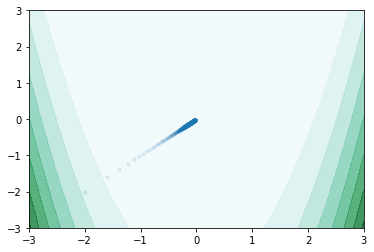

In [310]:
x,y = Variable(),Variable()
f= 100.0*(y - x**2)**2 + (1 - x)**2.0
plot_contour(f, {x:-2,y:-1}, plot_range=[-3,3],method = 'gradient_descent')

[[-0.5, -7.0], [-0.5, -7.0]]

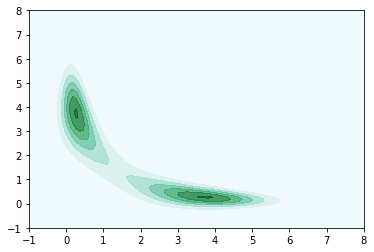

In [292]:
x,y = Variable(),Variable()
f= exp(-(x*x*y*y+x*x+y*y-8*x-8*y)/2.)
plot_range=[-1,8]
a=gradient_descent(f, {x: -0.5,y:-7},return_history=True)
xx=np.linspace(plot_range[0],plot_range[1],100)
yy=np.linspace(plot_range[0],plot_range[1],100)
xg,yg = np.meshgrid(xx,yy)
z=np.zeros(shape=(len(xg.ravel()),))
for i,val in enumerate(xg.ravel()):
    vals = yg.ravel()
    z[i]=f.evaluation_at({x:val,y:vals[i]})
z2 = z.reshape(xg.shape)
plt.contourf(xg,yg,z2,alpha=0.8, cmap="BuGn")
a

In [276]:
a

[[-2, -2],
 [-1.997502081598668, 3.9900083263946717],
 [0.9962640215968228, -7.970093479914039],
 [0.9962661046310918, 0.99254615123247],
 [0.9999999999967593, 0.9999860580189168],
 [0.999999999999991, 0.999999999999982]]

In [144]:
f= 100.0*(y - x**2)**2 + (1 - x)**2.0
gradient_descent(f, {x:0,y:1})


/Users/ting/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:278: RuntimeWarning: overflow encountered in power
/Users/ting/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:203: RuntimeWarning: invalid value encountered in double_scalars


{<__main__.Variable at 0x113ba0278>: nan,
 <__main__.Variable at 0x113ba06d8>: nan}

In [89]:
f.hessian_at({x: 2,y:2})

array([[ 2.,  0.],
       [ 0.,  2.]])

In [90]:
np.linalg.solve(f.hessian_at({x: 2,y:2}),-f.gradient_at({x: 2,y:2}))

array([-1., -2.])

In [63]:
x, y = Variable(), Variable()
f=100.0*(y - x**2)**2 + (1 - x)**2.0
f_grad=f.gradient_at({x: 0.0, y: 1.0})
f_hess=f.hessian_at({x: 0.0, y: 1.0})
np.linalg.solve(f_hess, -f_grad)

array([-0.00502513, -1.        ])

In [55]:
x, y = Variable(), Variable()
f=100.0*(y - x**2)**2 + (1 - x)**2.0


array([[-398.,    0.],
       [   0.,  200.]])

In [56]:
dict1= {x: 0.0, y: 1.0}

In [61]:
dict1.values()

dict_values

In [65]:
a=np.array([v for k, v in dict1.items()])

In [66]:
a+np.linalg.solve(f_hess, -f_grad)

array([-0.00502513,  0.        ])

In [103]:
np.empty(3)

array([  3.10503618e+231,   3.11109133e+231,   3.45845952e-323])

In [104]:
len(dict1)

2